In [ ]:
from glob import glob 
from keras.preprocessing.image import img_to_array, array_to_img, ImageDataGenerator, load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout, Activation, Input, add
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.utils import plot_model
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import LearningRateScheduler

In [ ]:
batch_size = 32
train_datagen = ImageDataGenerator(rescale = 1. / 255,
                                   horizontal_flip = True,
                                   zoom_range = 0.3, )
test_datagen = ImageDataGenerator(rescale = 1. / 255)


In [ ]:
train_gen = train_datagen.flow_from_directory(train_path, 
                                              target_size =(100, 100),
                                              batch_size = batch_size,
                                              color_mode = 'rgb',
                                              class_mode = 'categorical')
test_gen = test_datagen.flow_from_directory(test_path, 
                                              target_size =(100, 100),
                                              batch_size = batch_size,
                                              color_mode = 'rgb',
                                              class_mode = 'categorical')


In [ ]:
def lr_schedule(epoch):
  lr = 0.01
  if epoch > 80:
    lr *= 0.5e-3
  elif epoch > 60:
    lr *= 1e-3
  elif epoch > 40:
    lr *= 1e-2
  elif epoch > 20:
    lr *= 1e-1
  print('Learning rate : ', lr)
  return lr


In [ ]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(num_classes)

In [ ]:
def residual_module(layer_in, n_filters):
	merge_input = layer_in
	# check if the number of filters needs to be increase, assumes channels last format
	if layer_in.shape[-1] != n_filters:
		merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv1
	conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
	# conv2
	conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
	# add filters, assumes filters/channels last
	layer_out = add([conv2, merge_input])
	# activation function
	# layer_out = GlobalAveragePooling2D()(layer_out)
  # layer_out = Dropout(0.2)(layer_out)
  # layer_out = prediction_layer(layer_out)
  # layer_out = Activation('relu')(layer_out)
	return layer_out

In [ ]:
input = Input(shape = (100, 100, 3))

In [ ]:
optimizer = Adam(learning_rate = 0.1)

In [ ]:
layer = residual_module(input, 64)
layer = GlobalAveragePooling2D()(layer)
layer = Dropout(0.2)(layer)
layer = prediction_layer(layer)
layer = Activation('sigmoid')(layer)
model = Model(inputs = input, outputs = layer)
model.compile(loss = 'categorical_crossentropy', 
              optimizer = optimizer, metrics = ['accuracy'])
model.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 100, 100, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 100, 100, 64) 36928       conv2d_31[0][0]                  
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 100, 100, 64) 256         input_5[0][0]                    
______________________________________________________________________________________

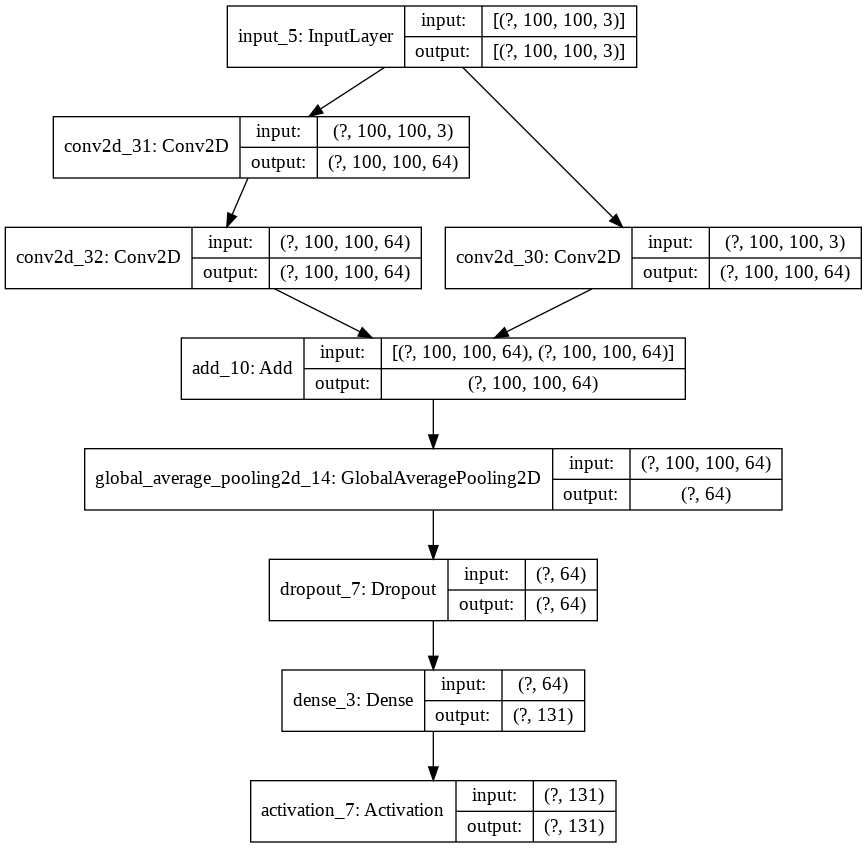

In [ ]:
plot_model(model, show_shapes = True)

In [ ]:
callbacks = LearningRateScheduler(lr_schedule)

In [ ]:
hist = model.fit_generator(generator = train_gen,
                           steps_per_epoch = 1600 // batch_size,
                           epochs = 100,
                           validation_data = test_gen,
                           validation_steps = 800 // batch_size,
                           callbacks = [callbacks])